# Example 13 Electron and nuclear spin mixed state dynamics with [RadicalPy](https://github.com/Spin-Chemistry-Labs/radicalpy)

In this tutorial, one constructs MPO of radical pair system (two electron spins and a couple of nuclear spins under magnetic field) by using RadicalPy library.

For parallelization number of threads should be set before importing any packages

In [1]:
import multiprocessing as mp
mp.set_start_method('fork', force=True) 
# <-- Spawn (Mac OS default) does not work. 
# If you want, change code to adopt main() block and separate process_pair() from main()

nthreads = 1
import os

os.environ["OMP_NUM_THREADS"] = f"{nthreads}"
os.environ["OPENBLAS_NUM_THREADS"] = f"{nthreads}"
os.environ["MKL_NUM_THREADS"] = f"{nthreads}"
os.environ["VECLIB_MAXIMUM_THREADS"] = f"{nthreads}"
os.environ["NUMEXPR_NUM_THREADS"] = f"{nthreads}"

Import required modules

In [2]:
try:
    import radicalpy
except ModuleNotFoundError:
    # remove uv if you are not using uv
    !uv pip install radicalpy --quiet

!uv pip show radicalpy

Using Python 3.12.2 environment at: /home/hinom/GitHub/PyTDSCF/.venv
Name: radicalpy
Version: 0.8.1
Location: /home/hinom/GitHub/PyTDSCF/.venv/lib/python3.12/site-packages
Requires: dot2tex, graphviz, importlib-resources, matplotlib, numpy, pint, scikit-learn, scipy, seaborn, sympy, tqdm
Required-by:


In [3]:
import concurrent.futures
import itertools
import time
from concurrent.futures import ProcessPoolExecutor

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import radicalpy as rp
from scipy.linalg import expm
from IPython.display import HTML
from pytdscf import BasInfo, Exciton, Model, Simulator, units
from pytdscf.dvr_operator_cls import TensorOperator
from pytdscf.hamiltonian_cls import TensorHamiltonian
from pytdscf.util.anim_density_matrix import get_anim
from radicalpy.simulation import State
from scipy.stats import qmc
from sympy import Symbol
from tqdm.auto import tqdm

from pympo import (
    AssignManager,
    OpSite,
    SumOfProducts,
)

## Total Hamiltonian
$$
\hat{H}_{\text{total}} =
\hat{H}_{\text{Z}} + \hat{H}_{\text{H}} + \hat{H}_{\text{J}} + \hat{H}_{\text{D}}    
$$

## Define systems

```py
# You can use following block instead
n_nuc_spins = 3 # In total, 3*2=6 nuclear spins + 2 electrons = 2^8 Hilbert space
flavin = rp.simulation.Molecule.fromisotopes(
    isotopes=["1H"] * n_nuc_spins, hfcs=[0.4] * n_nuc_spins
)
Z = rp.simulation.Molecule.fromisotopes(
    isotopes=["1H"] * n_nuc_spins, hfcs=[0.5] * n_nuc_spins
)
sim = rp.simulation.HilbertSimulation([flavin, Z])

# Parameters
A = {} # mT
isotropic = True

# Isotropic
for i in range(len(sim.radicals)):
    for j, nuc in enumerate(sim.molecules[i].nuclei):
        if isotropic:
            A[(i, j)] = np.eye(3) * nuc.hfc.isotropic
        else:
            A[(i, j)] = nuc.hfc.anisotropic
B0 = 0.2 # 2J
B = np.array((0.0, 0.0, 1.0)) * B0 # mT
J = 0.1 # Typically 1.0e+03 scale # mT

D = 1.0 # mT

if isinstance(D, float):
    D = 2 / 3 * np.diag((-1.0, -1.0, 2.0)) * D *sim.radicals[0].gamma_mT
sim
```

In [4]:
flavin = rp.simulation.Molecule.all_nuclei("flavin_anion")
trp = rp.simulation.Molecule.all_nuclei("tryptophan_cation")
sim = rp.simulation.HilbertSimulation([flavin, trp])
A = {}
isotropic = False

# Isotropic
for i in range(len(sim.radicals)):
    for j, nuc in enumerate(sim.molecules[i].nuclei):
        if isotropic:
            A[(i, j)] = np.eye(3) * nuc.hfc.isotropic
        else:
            A[(i, j)] = nuc.hfc.anisotropic
B0 = 3.0 # Typically 0.01 mT~10 mT 
B = np.array((0.0, 0.0, 1.0)) * B0
J = 0.1 # Typically 1.0e+03 scale

D = np.array([[-0.225,  0.156,  0.198],
              [ 0.156,  0.117, -0.082],
              [ 0.198, -0.082,  0.107]]) * sim.radicals[0].gamma_mT
# k = 1.0e-06 # Exponential model in s-1
if isinstance(D, float):
    D = 2 / 3 * np.diag((-1.0, -1.0, 2.0)) * D *sim.radicals[0].gamma_mT

sim

Number of electrons: 2
Number of nuclei: 27
Number of particles: 29
Multiplicities: [2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2]
Magnetogyric ratios (mT): [-176085963.023, -176085963.023, 19337.792, 19337.792, 19337.792, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 19337.792, 267522.18744, 19337.792, 19337.792, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744]
Nuclei: [14N(19337792.0, 3, 0.5141 <anisotropic available>), 14N(19337792.0, 3, -0.001275 <anisotropic available>), 14N(19337792.0, 3, -0.03654 <anisotropic available>), 1H(267522187.44, 2, 0.05075 <anisotropic available>), 1H(267522187.44, 2, -0.1371 <anisotropic available>), 1H(267522187.44, 2, -0.1371 <anisotropic available>), 1H(267522187.44, 2, -0.1371 <anisotropic available>), 1H(267522187.44, 2, -0.

Now, one defines matrix product state (MPS) in the following order

(nuclei in `flavin`) $\to$ (electronic states $\{|T_{+}\rangle, |T_{0}\rangle, |S\rangle, |T_{-}\rangle\}$) $\to$ (neclei in `Z`)

## Extract one particle operator

RadicalPy provides variety of spin operators such as 

- $\hat{s}_x, \hat{s}_y, \hat{s}_z$ for radical singlet-triplet basis
- $\hat{I}_x, \hat{I}_y, \hat{I}_z$ for nuclear Zeeman basis

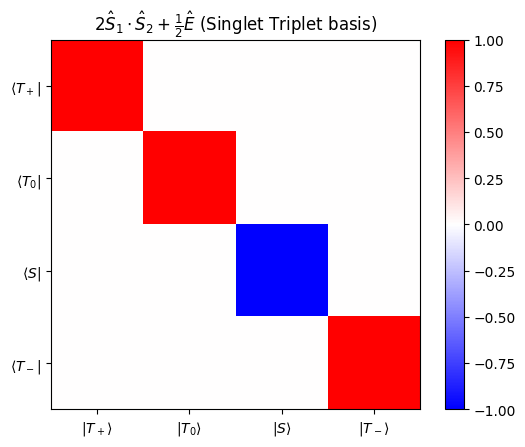

In [5]:
# Clear nuclei temporally
_nuclei_tmp0 = sim.molecules[0].nuclei
_nuclei_tmp1 = sim.molecules[1].nuclei
sim.molecules[0].nuclei = []
sim.molecules[1].nuclei = []

# for Singlet-Triplet basis
sx_1 = sim.spin_operator(0, "x")  
sy_1 = sim.spin_operator(0, "y").imag # <== Caution!
sz_1 = sim.spin_operator(0, "z")
sx_2 = sim.spin_operator(1, "x")
sy_2 = sim.spin_operator(1, "y").imag # <== Caution!
sz_2 = sim.spin_operator(1, "z") 

# Revert nuclei
sim.molecules[0].nuclei = _nuclei_tmp0
sim.molecules[1].nuclei = _nuclei_tmp1

plt.imshow(
    2*(sx_1 @ sx_2 - sy_1 @ sy_2 + sz_1 @ sz_2).real+0.5*np.eye(*sx_1.shape),
    cmap="bwr",
    vmin=-1.0,
    vmax=1.0,
)
plt.title(r"$2\hat{S}_1\cdot \hat{S}_2 + \frac{1}{2}\hat{E}$ (Singlet Triplet basis)")
plt.colorbar()
plt.xticks(
    [0, 1, 2, 3],
    [r"$|T_+\rangle$", r"$|T_0\rangle$", r"$|S\rangle$", r"$|T_-\rangle$"],
)
plt.yticks(
    [0, 1, 2, 3],
    [
        r"$\langle T_+|$",
        r"$\langle T_0 |$",
        r"$\langle S|$",
        r"$\langle T_- |$",
    ],
)
plt.show()

## Define `OpSite` and coefficients

- RadicalPy uses Hz in energy unit but it is too large to keep numerical stabiltiy
- Thus, one will use GHz in energy unit
- For some reasons, extraction of imaginary unit of pauli y operator leads stable simulation for degenerate system (why??)

In [6]:
SCALE = 1.0e-09
gamma = [p.gamma_mT for p in sim.particles]

g_ele_sym = [
    Symbol(r"\gamma_e^{(" + f"{i + 1}" + ")}") for i in range(len(sim.radicals))
]
g_nuc_sym = {}
for i in range(len(sim.radicals)):
    for j in range(len(sim.molecules[i].nuclei)):
        g_nuc_sym[(i,j)] = Symbol(r"\gamma_n^{" + f"{(i + 1, j + 1)}" + "}")

subs = {}
for i, ge in enumerate(g_ele_sym):
    subs[ge] = sim.radicals[i].gamma_mT
for (i,j), gn in g_nuc_sym.items():
    subs[gn] = sim.molecules[i].nuclei[j].gamma_mT

Define radical spin operators

In [7]:
ele_site = len(sim.molecules[0].nuclei)

Sx_ops = []
Sy_ops = []
Sz_ops = []

S1S2_op = OpSite(
    r"\hat{S}_1\cdot\hat{S}_2",
    ele_site,
    value=(sx_1 @ sx_2 - sy_1 @ sy_2 + sz_1 @ sz_2).real,
)
E_op = OpSite(r"\hat{E}", ele_site, value=np.eye(*sx_1.shape))

Sx_ops.append(OpSite(r"\hat{S}_x^{(1)}", ele_site, value=sx_1))
Sy_ops.append(OpSite(r"\hat{S}_y^{(1)}", ele_site, value=sy_1))
Sz_ops.append(OpSite(r"\hat{S}_z^{(1)}", ele_site, value=sz_1))
Sx_ops.append(OpSite(r"\hat{S}_x^{(2)}", ele_site, value=sx_2))
Sy_ops.append(OpSite(r"\hat{S}_y^{(2)}", ele_site, value=sy_2))
Sz_ops.append(OpSite(r"\hat{S}_z^{(2)}", ele_site, value=sz_2))

Sr_ops = [Sx_ops, Sy_ops, Sz_ops]

sz_1 * sz_2 - sz_1@sz_2

array([[ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.25, -0.25,  0.  ],
       [ 0.  , -0.25,  0.25,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ]])

Define nuclear spin operators

In [8]:
Ix_ops = {}
Iy_ops = {}
Iz_ops = {}

for j, nuc in enumerate(sim.molecules[0].nuclei):
    Ix_ops[(0, j)] = OpSite(
        r"\hat{I}_x^{" + f"{(1, j + 1)}" + "}", j, value=nuc.pauli["x"]
    )
    Iy_ops[(0, j)] = OpSite(
        r"\hat{I}_y^{" + f"{(1, j + 1)}" + "}", j, value=nuc.pauli["y"].imag
    )
    Iz_ops[(0, j)] = OpSite(
        r"\hat{I}_z^{" + f"{(1, j + 1)}" + "}", j, value=nuc.pauli["z"]
    )

for j, nuc in enumerate(sim.molecules[1].nuclei):
    Ix_ops[(1, j)] = OpSite(
        r"\hat{I}_x^{" + f"{(2, j + 1)}" + "}",
        ele_site + 1 + j,
        value=nuc.pauli["x"],
    )
    Iy_ops[(1, j)] = OpSite(
        r"\hat{I}_y^{" + f"{(2, j + 1)}" + "}",
        ele_site + 1 + j,
        value=nuc.pauli["y"].imag,
    )
    Iz_ops[(1, j)] = OpSite(
        r"\hat{I}_z^{" + f"{(2, j + 1)}" + "}",
        ele_site + 1 + j,
        value=nuc.pauli["z"],
    )

Ir_ops = [Ix_ops, Iy_ops, Iz_ops]

## Hyperfine coupling Hamiltonian
$$
\hat{H}_{\text{H}} = \sum_i \sum_j \hat{S}_i\cdot A_{ij}\cdot \hat{I}_{ij}
= \sum_i \sum_j \sum_{r\in\{x, y, z\}} A_{ij}\hat{S}_{r}^{(i)}\hat{I}_{r}^{(ij)}
$$

In [9]:
hyperfine = SumOfProducts()

xyz = "xyz"

for i in range(len(sim.radicals)):
    for j in range(len(sim.molecules[i].nuclei)):
        for k, Sr_op in enumerate(Sr_ops):
            for l, Ir_op in enumerate(Ir_ops):
                if A[(i, j)][k, l] == 0.0:
                    continue
                Asym = Symbol(
                    "A^{"
                    + f"{(i + 1, j + 1)}"
                    + "}_{"
                    + f"{xyz[k]}"
                    + f"{xyz[l]}"
                    + "}"
                )
                subs[Asym] = A[(i, j)][k, l].item() * SCALE
                if k==l==1:
                    hyperfine -= Asym * g_ele_sym[i] * Sr_op[i] * Ir_op[(i, j)]
                elif k!=1 and l!= 1:
                    hyperfine += Asym * g_ele_sym[i] * Sr_op[i] * Ir_op[(i, j)]
                else:
                    hyperfine += 1.0j * Asym * g_ele_sym[i] * Sr_op[i] * Ir_op[(i, j)]

In [10]:
hyperfine = hyperfine.simplify()
hyperfine.symbol

A^{(1, 1)}_{xx}*\gamma_e^{(1)}*\hat{I}_x^{(1, 1)}*\hat{S}_x^{(1)} + 1.0*I*A^{(1, 1)}_{xy}*\gamma_e^{(1)}*\hat{I}_y^{(1, 1)}*\hat{S}_x^{(1)} + A^{(1, 1)}_{xz}*\gamma_e^{(1)}*\hat{I}_z^{(1, 1)}*\hat{S}_x^{(1)} + 1.0*I*A^{(1, 1)}_{yx}*\gamma_e^{(1)}*\hat{I}_x^{(1, 1)}*\hat{S}_y^{(1)} - A^{(1, 1)}_{yy}*\gamma_e^{(1)}*\hat{I}_y^{(1, 1)}*\hat{S}_y^{(1)} + 1.0*I*A^{(1, 1)}_{yz}*\gamma_e^{(1)}*\hat{I}_z^{(1, 1)}*\hat{S}_y^{(1)} + A^{(1, 1)}_{zx}*\gamma_e^{(1)}*\hat{I}_x^{(1, 1)}*\hat{S}_z^{(1)} + 1.0*I*A^{(1, 1)}_{zy}*\gamma_e^{(1)}*\hat{I}_y^{(1, 1)}*\hat{S}_z^{(1)} + A^{(1, 1)}_{zz}*\gamma_e^{(1)}*\hat{I}_z^{(1, 1)}*\hat{S}_z^{(1)} + A^{(1, 10)}_{xx}*\gamma_e^{(1)}*\hat{I}_x^{(1, 10)}*\hat{S}_x^{(1)} + 1.0*I*A^{(1, 10)}_{xy}*\gamma_e^{(1)}*\hat{I}_y^{(1, 10)}*\hat{S}_x^{(1)} + A^{(1, 10)}_{xz}*\gamma_e^{(1)}*\hat{I}_z^{(1, 10)}*\hat{S}_x^{(1)} + 1.0*I*A^{(1, 10)}_{yx}*\gamma_e^{(1)}*\hat{I}_x^{(1, 10)}*\hat{S}_y^{(1)} - A^{(1, 10)}_{yy}*\gamma_e^{(1)}*\hat{I}_y^{(1, 10)}*\hat{S}_y^{(1)} + 1.

## Zeeman Hamiltonian
$$
\hat{H}_{\text{Z}}
= - \vec{B} \cdot \sum_i \left(\gamma_{\text{e}}\vec{S}^{(i)} + \left(\sum_j\gamma_{\text{n}}^{(ij)}\vec{I}^{(ij)}\right)\right)
$$

In [11]:
zeeman = SumOfProducts()

xyz = "xyz"

for k, (Sr_op, Ir_op) in enumerate(zip(Sr_ops, Ir_ops, strict=True)):
    if B[k] == 0.0:
        continue
    r = xyz[k]
    Br = Symbol(f"B_{r}")
    subs[Br] = B[k] * SCALE
    for i in range(len(sim.radicals)):
        if k== 1:
            zeeman += -1.0j*Br * g_ele_sym[i] * Sr_op[i]
        else:
            zeeman += -Br * g_ele_sym[i] * Sr_op[i]
        for j in range(len(sim.molecules[i].nuclei)):
            if k == 1:
                zeeman += -1.0j*Br * g_nuc_sym[(i,j)] * Ir_op[(i, j)]
            else:
                zeeman += -Br * g_nuc_sym[(i,j)] * Ir_op[(i, j)]

zeeman = zeeman.simplify()
zeeman.symbol

-B_z*\gamma_e^{(1)}*\hat{S}_z^{(1)} - B_z*\gamma_e^{(2)}*\hat{S}_z^{(2)} - B_z*\gamma_n^{(1, 1)}*\hat{I}_z^{(1, 1)} - B_z*\gamma_n^{(1, 10)}*\hat{I}_z^{(1, 10)} - B_z*\gamma_n^{(1, 11)}*\hat{I}_z^{(1, 11)} - B_z*\gamma_n^{(1, 12)}*\hat{I}_z^{(1, 12)} - B_z*\gamma_n^{(1, 13)}*\hat{I}_z^{(1, 13)} - B_z*\gamma_n^{(1, 14)}*\hat{I}_z^{(1, 14)} - B_z*\gamma_n^{(1, 15)}*\hat{I}_z^{(1, 15)} - B_z*\gamma_n^{(1, 16)}*\hat{I}_z^{(1, 16)} - B_z*\gamma_n^{(1, 2)}*\hat{I}_z^{(1, 2)} - B_z*\gamma_n^{(1, 3)}*\hat{I}_z^{(1, 3)} - B_z*\gamma_n^{(1, 4)}*\hat{I}_z^{(1, 4)} - B_z*\gamma_n^{(1, 5)}*\hat{I}_z^{(1, 5)} - B_z*\gamma_n^{(1, 6)}*\hat{I}_z^{(1, 6)} - B_z*\gamma_n^{(1, 7)}*\hat{I}_z^{(1, 7)} - B_z*\gamma_n^{(1, 8)}*\hat{I}_z^{(1, 8)} - B_z*\gamma_n^{(1, 9)}*\hat{I}_z^{(1, 9)} - B_z*\gamma_n^{(2, 1)}*\hat{I}_z^{(2, 1)} - B_z*\gamma_n^{(2, 10)}*\hat{I}_z^{(2, 10)} - B_z*\gamma_n^{(2, 11)}*\hat{I}_z^{(2, 11)} - B_z*\gamma_n^{(2, 2)}*\hat{I}_z^{(2, 2)} - B_z*\gamma_n^{(2, 3)}*\hat{I}_z^{(2, 3)} - B_z*

## Exchange Hamiltonian
$$
\hat{H}_{\text{J}}
= J \gamma_e \left(\vec{S}_1\cdot\vec{S_2}+\frac{1}{2}\hat{E}\right)
$$

In [12]:
exchange = SumOfProducts()
Jsym = Symbol("J")
subs[Jsym] = J * SCALE
exchange += Jsym * g_ele_sym[0] * (2*S1S2_op + 0.5 * E_op)
exchange = exchange.simplify()
exchange.symbol

0.5*J*\gamma_e^{(1)}*\hat{E} + 2*J*\gamma_e^{(1)}*\hat{S}_1\cdot\hat{S}_2

## Dipolar Hamiltonian
$$
\hat{H}_{\text{J}}
= \vec{S}_1^\top \cdot D \cdot \vec{S_2}
$$

In [13]:
dipolar = SumOfProducts()
for k in range(3):
    for l in range(3):
        if D[k, l] == 0.0:
            continue
        else:
            Dsym = Symbol(
                    "D_{"
                    + f"{xyz[k]}"
                    + f"{xyz[l]}"
                    + "}"
                )
            subs[Dsym] = D[k,l] *SCALE
            if k == l == 1:
                dipolar += -Dsym * Sr_ops[k][0] * Sr_ops[l][1]
            elif k != 1 and l != 1:
                dipolar += Dsym * Sr_ops[k][0] * Sr_ops[l][1]
            else:
                dipolar += 1.0j*Dsym * Sr_ops[k][0] * Sr_ops[l][1]
dipolar = dipolar.simplify()
dipolar.symbol

D_{xx}*\hat{S}_x^{(1)}*\hat{S}_x^{(2)} + 1.0*I*D_{xy}*\hat{S}_x^{(1)}*\hat{S}_y^{(2)} + D_{xz}*\hat{S}_x^{(1)}*\hat{S}_z^{(2)} + 1.0*I*D_{yx}*\hat{S}_y^{(1)}*\hat{S}_x^{(2)} - D_{yy}*\hat{S}_y^{(1)}*\hat{S}_y^{(2)} + 1.0*I*D_{yz}*\hat{S}_y^{(1)}*\hat{S}_z^{(2)} + D_{zx}*\hat{S}_z^{(1)}*\hat{S}_x^{(2)} + 1.0*I*D_{zy}*\hat{S}_z^{(1)}*\hat{S}_y^{(2)} + D_{zz}*\hat{S}_z^{(1)}*\hat{S}_z^{(2)}

Construct matrix product operator (MPO) for MPS propagation

In [14]:
hamiltonian = hyperfine + zeeman + exchange + dipolar
hamiltonian = hamiltonian.simplify()
am = AssignManager(hamiltonian)
_ = am.assign()
# display(*am.Wsym)
mpo = am.numerical_mpo(subs=subs)

2025-06-11 14:06:21.066 | INFO     | pympo.bipartite:assign:286 - assigned 1/28
2025-06-11 14:06:21.078 | INFO     | pympo.bipartite:assign:286 - assigned 2/28
2025-06-11 14:06:21.112 | INFO     | pympo.bipartite:assign:286 - assigned 3/28
2025-06-11 14:06:21.141 | INFO     | pympo.bipartite:assign:286 - assigned 4/28
2025-06-11 14:06:21.158 | INFO     | pympo.bipartite:assign:286 - assigned 5/28
2025-06-11 14:06:21.169 | INFO     | pympo.bipartite:assign:286 - assigned 6/28
2025-06-11 14:06:21.182 | INFO     | pympo.bipartite:assign:286 - assigned 7/28
2025-06-11 14:06:21.198 | INFO     | pympo.bipartite:assign:286 - assigned 8/28
2025-06-11 14:06:21.208 | INFO     | pympo.bipartite:assign:286 - assigned 9/28
2025-06-11 14:06:21.218 | INFO     | pympo.bipartite:assign:286 - assigned 10/28
2025-06-11 14:06:21.228 | INFO     | pympo.bipartite:assign:286 - assigned 11/28
2025-06-11 14:06:21.236 | INFO     | pympo.bipartite:assign:286 - assigned 12/28
2025-06-11 14:06:21.246 | INFO     | 

## Mixed state (ensemble) simulation

In [15]:
backend = "numpy"
m = 32 # Bond dimension
Δt = 5.0e-10 / SCALE * units.au_in_fs  # dt = 0.5 ns

spin_coherent = True # Whether or not use coherent state sampling

In [16]:
basis = []
for nuc in sim.molecules[0].nuclei:
    basis.append(Exciton(nstate=nuc.multiplicity))
basis.append(Exciton(nstate=4))
for nuc in sim.molecules[1].nuclei:
    basis.append(Exciton(nstate=nuc.multiplicity))
basinfo = BasInfo([basis], spf_info=None)

nsite = len(basis)

In [17]:
op_dict = {
    tuple([(isite, isite) for isite in range(nsite)]): TensorOperator(mpo=mpo)
}
H = TensorHamiltonian(
    nsite, potential=[[op_dict]], kinetic=None, backend=backend
)

In [18]:
def spin_coherenet_state(pair):
    """
    J. Chem. Phys. 154, 084121 (2021); doi: 10.1063/5.0040519

    Sample from spin coherent state
    |Ω⁽ᴵ⁾⟩ = cos(θ/2)²ᴵ exp(tan(θ/2)exp(iϕ)Î₋) |I,I⟩
    """
    hp = []
    for isite in range(nsite):
        if isite == ele_site:
            hp.append([0, 0, 1, 0])  # Singlet
        else:
            mult = basis[isite].nstate
            I = (mult - 1) / 2
            nind = isite - int(ele_site <= isite)
             
            theta = np.arccos(pair[2*nind] * 2-1.0)
            # same as
            # theta = np.arcsin(pair[2*nind] * 2 - 1.0)
            # if theta < 0:
            #    theta += np.pi
            phi = pair[2*nind+1] * 2 * np.pi
            weights = np.zeros((mult,1))
            weights[0, 0] = 1.0
            weights = (np.cos(theta / 2) ** (2*I)) * expm(np.tan(theta/2) * np.exp(1.0j*phi) * sim.nuclei[nind].pauli['m'])  @ weights
            assert abs((weights.conjugate().T @ weights).real[0,0] -1.0) < 1.0e-14, (weights.conjugate().T @ weights)[0,0]
            #print(weights.conjugate().T @ weights, weights)
            hp.append(weights.reshape(-1).tolist())
    return hp

def projection_state(pair):
    """
    Sampel from projection state |M⟩
    """
    init_nuc_spins = [np.floor(pair[i] * basis[i + int(ele_site <= i)].nstate).astype(int) for i in range(nsite - 1)]
    hp = []
    for isite in range(nsite):
        if isite == ele_site:
            hp.append([0, 0, 1, 0])  # Singlet
        else:
            weights = np.zeros(basis[isite].nstate)
            weights[init_nuc_spins[isite - int(ele_site <= isite)]] = 1.0
            hp.append(weights.tolist())
    return hp
    
    
def process_pair(pair, i, H):
    operators = {"hamiltonian": H}
    model = Model(basinfo=basinfo, operators=operators)
    model.m_aux_max = m
    if spin_coherent:
        hp = spin_coherenet_state(pair)
    else:
        hp = projection_state(pair)
    model.init_HartreeProduct = [hp]

    jobname = f"radicalpair_{i}"
    simulator = Simulator(
        jobname=jobname, model=model, backend=backend, verbose=0
    )
    ener, wf = simulator.propagate(
        reduced_density=(
            [(ele_site, ele_site)],
            2,
        ),
        maxstep=100,
        stepsize=Δt,
        autocorr=False,
        energy=False,
        norm=False,
        populations=False,
    )

    with nc.Dataset(f"{jobname}_prop/reduced_density.nc", "r") as file:
        density_data_real = file.variables[f"rho_({ele_site}, {ele_site})_0"][
            :
        ]["real"]
        density_data_imag = file.variables[f"rho_({ele_site}, {ele_site})_0"][
            :
        ]["imag"]
        time_data = file.variables["time"][:]

    density_data = np.array(density_data_real) + 1.0j * np.array(
        density_data_imag
    )
    time_data = np.array(time_data)

    return density_data, time_data

Since nuclear spins are mixed state, one needs to consider ensemble of nuclear spin initial states. 
The calculation is performed in parallel for each trajectory.
When the number of nuclear spins large, switch to quasi Monte Carlo approach. 

In [19]:
futures = []
density_sum = None

# If number of nuclear spin is larger than 6, 
# initial states are randomly sampled by quasi Monte Carlo
is_mc = len(basis) -1 > 5

if spin_coherent:
    engine = qmc.Sobol(d=2*(nsite - 1), scramble=True)
else:
    engine = qmc.Sobol(d=nsite - 1, scramble=True)
pairs = engine.random(n=2**7) # sample from [0, 1]^N hypercubic

In [20]:
density_sums = []
# execute `max_workers` process in parallel
max_workers = 8
with ProcessPoolExecutor(max_workers=max_workers) as executor:
    try:
        density_sum = None
        active_futures = []
        i = 0 # number of submitted jobs
        j = 0 # number of finished jobs

        pbar = tqdm(total=len(pairs), desc="Processing pairs")
        while i < len(pairs) or active_futures:
            # Submit new jobs up to max_active
            while len(active_futures) < max_workers and i < len(pairs):
                future = executor.submit(process_pair, pairs[i], i, H)
                active_futures.append((future, i))
                i += 1

            # Wait for at least one job to complete
            done, not_done = concurrent.futures.wait(
                [f for f, _ in active_futures],
                return_when=concurrent.futures.FIRST_COMPLETED,
            )

            # Process completed jobs
            remaining_futures = []
            for future, job_i in active_futures:
                if future in done:
                    density_data, time_data = future.result()
                    if density_sum is None:
                        density_sum = density_data
                    else:
                        density_sum += density_data
                    j += 1
                    if is_mc and j >= 32 and j.bit_count() == 1:
                        # when j in [4, 8, 16, ...] record result to estimate convergence of Monte Carlo
                        density_sums.append(density_sum / j)
                    pbar.update(1)
                else:
                    remaining_futures.append((future, job_i))
            active_futures = remaining_futures

    except KeyboardInterrupt:
        print("\nCancelling active tasks...")
        for future, _ in active_futures:
            future.cancel()
        executor.shutdown(wait=False)
        pbar.close()
        raise

    pbar.close()

Processing pairs:   0%|          | 0/128 [00:00<?, ?it/s]

/home/hinom/.local/share/uv/python/cpython-3.12.2-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/hinom/.local/share/uv/python/cpython-3.12.2-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
2025-06-11 14:06:24,618 - INFO:main.pytdscf.simulator_cls - Set integral of FBR basis
2025-06-11 14:06:24,617 - INFO:main.pytdscf.simulator_cls - Set integral of FBR basis
2025-06-11 14:06:24,618 - INFO:main.pytdscf.simulator_cls - Set integral of FBR basis
2025-06-11 14:06:24,619 - INFO:main.pytdscf.simulator_cls - Set integral of FBR basis
2025-06-11 14:06:24,620 - INFO:main.pytdscf.simulator_cls - Set inte

In [21]:
time_data_μs = time_data * SCALE * 1e06 / units.au_in_fs
density_data = density_sum / len(pairs)

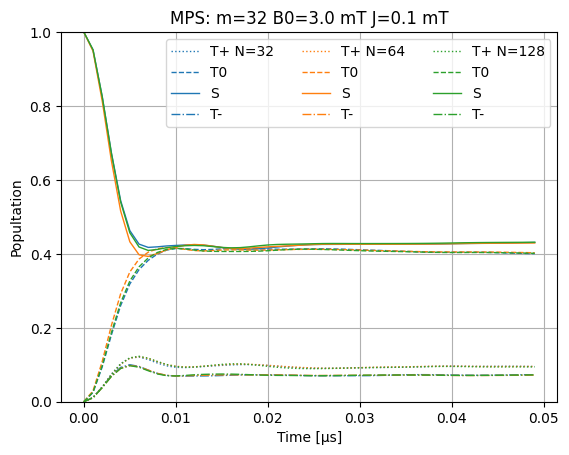

In [22]:
plt.clf()

for i, (density_data, color) in enumerate(zip(density_sums, plt.rcParams['axes.prop_cycle'].by_key()['color'])):
    plt.plot(time_data_μs, density_data[:, 0, 0].real, linewidth=1, ls="dotted", color=color, label=f"T+ N={2**(i+5)}")
    plt.plot(time_data_μs, density_data[:, 1, 1].real, linewidth=1, ls="dashed", color=color, label=f"T0")
    plt.plot(time_data_μs, density_data[:, 2, 2].real, linewidth=1, ls="solid", color=color, label=f"S")
    plt.plot(time_data_μs, density_data[:, 3, 3].real, linewidth=1, ls="dashdot", color=color, label=f"T-")
plt.title(f"MPS: {m=} {B0=} mT {J=} mT")
plt.legend(ncol=len(density_sums))
plt.xlabel("Time [μs]")
plt.ylabel("Popultation")
plt.grid()
plt.ylim([0, 1])
plt.savefig("population.png")
plt.show()

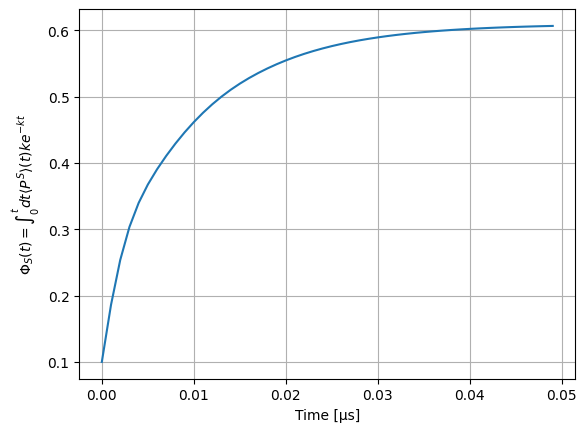

In [23]:
dt = time_data_μs[1] - time_data[0]
k_s = 1e+2 # 1/micro sec, typically 1.0~0.1
phi_s = np.cumsum(density_data[:, 2, 2].real * dt * k_s * np.exp(-k_s* time_data_μs))

plt.plot(time_data_μs, phi_s)
plt.xlabel("Time [μs]")
plt.ylabel(r"$\Phi_S(t)=\int_0^t dt \langle P^S \rangle(t) ke^{-kt} $")
plt.grid()
plt.savefig("population.png")
plt.show()

Saving animation to rdm-radical.gif...
Animation saved successfully!


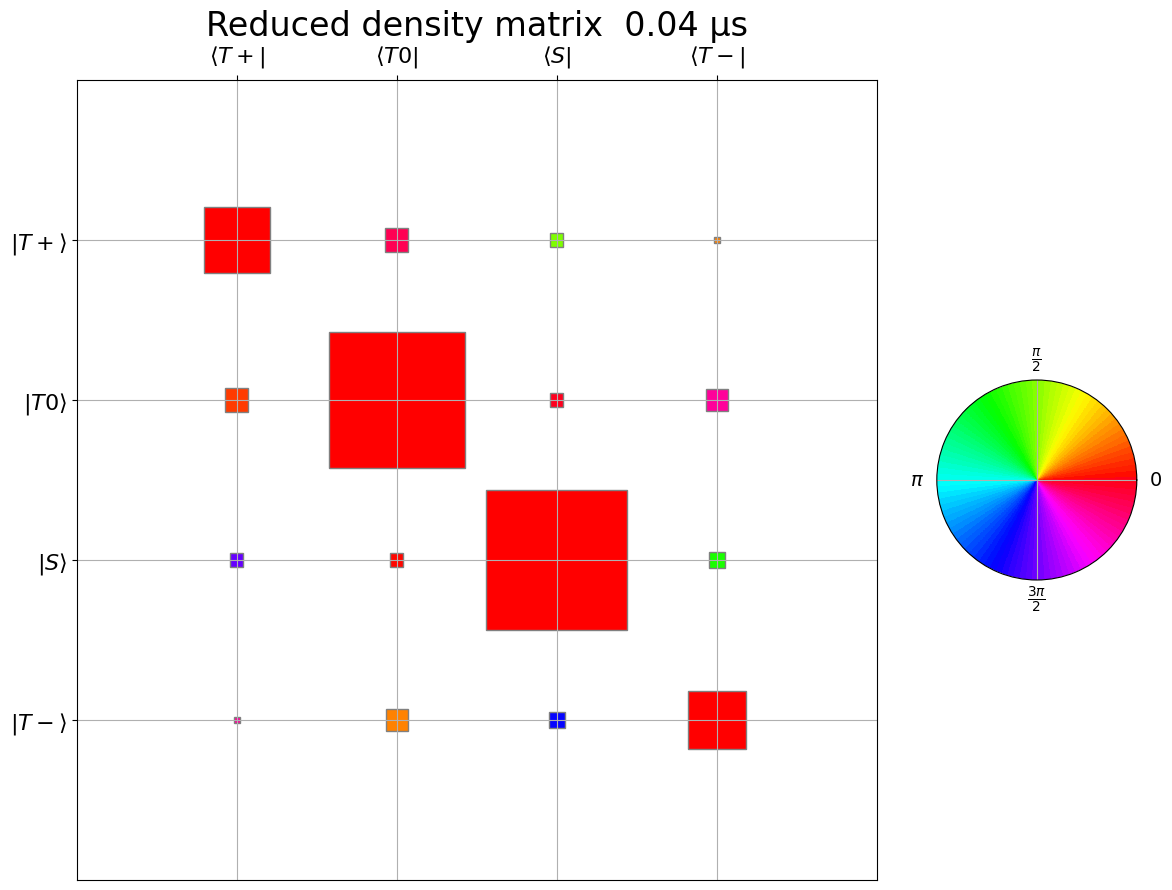

In [24]:
# Note: spin coherent state sampling has slower convergence for off-diagnal term than projection state sampling
fig, anim = get_anim(
    density_data[::10, :, :],
    time_data_μs[::10],
    title="Reduced density matrix",
    time_unit="μs",
    save_gif=True,
    dpi=30,
    gif_filename="rdm-radical.gif",
    row_names=[
        r"$|T+\rangle$",
        r"$|T0\rangle$",
        r"$|S\rangle$",
        r"$|T-\rangle$",
    ],
    col_names=[
        r"$\langle T+|$",
        r"$\langle T0|$",
        r"$\langle S|$",
        r"$\langle T-|$",
    ],
)
plt.show()
HTML(anim.to_jshtml())

## Compare with RadicalPy simulation

In [25]:
if len(basis) < 8:
    assert isinstance(D, np.ndarray)
    H = sim.total_hamiltonian(B0=B0, D=D, J=J)
    time = np.arange(0, 5e-8, 5e-10)
    rhos = sim.time_evolution(State.SINGLET, time, H)
    time_evol_s = sim.product_probability(State.SINGLET, rhos)
    time_evol_tp = sim.product_probability(State.TRIPLET_PLUS, rhos)
    time_evol_tz = sim.product_probability(State.TRIPLET_ZERO, rhos)
    time_evol_tm = sim.product_probability(State.TRIPLET_MINUS, rhos)
    x = time * 1e6

    plt.plot(x, time_evol_tp, linewidth=2, label="T+")
    plt.plot(x, time_evol_tz, linewidth=2, label="T0")
    plt.plot(x, time_evol_s, linewidth=2, label="S")
    plt.plot(x, time_evol_tm, linewidth=2, label="T-")
    plt.legend()
    plt.title(f"RadicalPy: Density Matrix Approach {B0=}, {J=}")
    plt.xlabel(r"Time ($\mu s$)")
    plt.ylabel("Probability")
    plt.ylim([0, 1])
    plt.show()

In [26]:
if len(basis) < 6:
    fig, anim = get_anim(
        rhos[::, :, :],
        x[::],
        title="Full density matrix",
        time_unit="μs",
        dpi=30,
    )
    plt.show()
    display(HTML(anim.to_jshtml()))
elif len(basis) < 8:
    red_rhos = np.einsum("tikjk->tij", rhos.reshape(rhos.shape[0], 4, rhos.shape[1] // 4, 4, rhos.shape[2] // 4))
    fig, anim = get_anim(
        red_rhos[::20, :, :],
        x[::20],
        title="Reduced density matrix",
        time_unit="μs",
        dpi=30,
    )
    plt.show()
    display(HTML(anim.to_jshtml()))

In [27]:
# Clean files
!rm -rf radicalpair_*_prop
!rm -f wf_radicalpair_*.pkl

/home/hinom/.local/share/uv/python/cpython-3.12.2-linux-x86_64-gnu/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
